# Movie Recommendation System using Collaborative Filtering

This notebook implements a movie recommendation system using different collaborative filtering techniques:
1. User-Based Collaborative Filtering
2. Item-Based Collaborative Filtering
3. Matrix Factorization using SVD (Singular Value Decomposition)

We'll evaluate each approach using appropriate metrics like RMSE and precision@k.

## 1. Setup and Data Loading

In [68]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from scipy.sparse.linalg import svds
from sklearn.model_selection import train_test_split

# Set random seed for reproducibility
np.random.seed(42)

In [69]:
# Load the datasets
ratings_df = pd.read_csv('ratings.csv')
movies_df = pd.read_csv('movies.csv')

# Display the first few rows of each dataset
print("Ratings Dataset:")
print(ratings_df.head())
print("\nMovies Dataset:")
print(movies_df.head())

Ratings Dataset:
   user_id  movie_id  rating  timestamp
0        1        10     4.0  964982703
1        1        20     3.5  964982224
2        1        30     1.5  964982699
3        1        40     5.0  964982845
4        1        50     3.0  964982834

Movies Dataset:
   movie_id                   title              genres
0        10       The Matrix (1999)       Action|Sci-Fi
1        20        Inception (2010)     Action|Thriller
2        30     The Notebook (2004)       Drama|Romance
3        40  The Dark Knight (2008)  Action|Crime|Drama
4        50          Titanic (1997)       Drama|Romance


Number of users: 15
Number of movies: 10
Number of ratings: 75


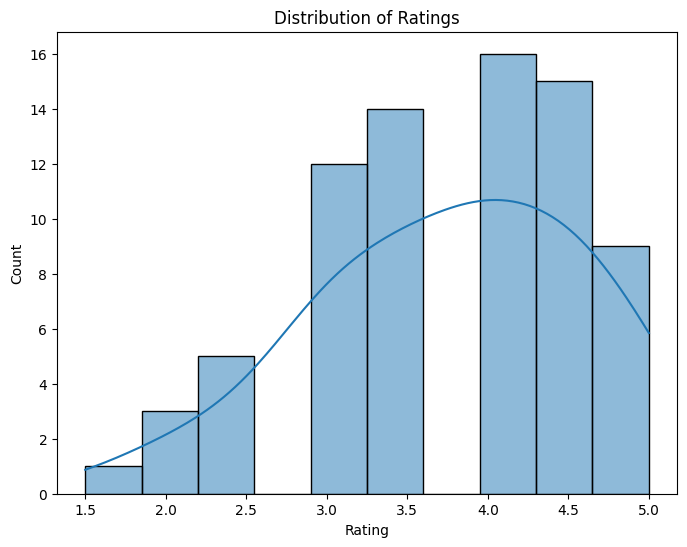

In [70]:
# Basic data exploration
print(f"Number of users: {ratings_df['user_id'].nunique()}")
print(f"Number of movies: {movies_df['movie_id'].nunique()}")
print(f"Number of ratings: {len(ratings_df)}")

# Distribution of ratings
plt.figure(figsize=(8, 6))
sns.histplot(ratings_df['rating'], bins=10, kde=True)
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

## 2. Data Preparation

In [83]:
# Create a user-item matrix
user_item_matrix = ratings_df.pivot(
    index='user_id',
    columns='movie_id',
    values='rating'
).fillna(0)

print("User-Item Matrix Shape:", user_item_matrix.shape)
user_item_matrix.head()

User-Item Matrix Shape: (15, 10)


movie_id,10,20,30,40,50,60,70,80,90,100
user_id,,,,,,,,,,
1,4.0,3.5,1.5,5.0,3.0,0.0,0.0,0.0,0.0,0.0
2,4.5,0.0,2.0,4.0,4.5,3.5,0.0,0.0,0.0,0.0
3,5.0,4.0,0.0,3.5,0.0,4.5,4.0,0.0,0.0,0.0
4,0.0,4.5,3.0,0.0,3.5,5.0,3.0,0.0,0.0,0.0
5,3.5,4.0,0.0,2.5,4.5,0.0,5.0,0.0,0.0,0.0


In [72]:
# Split data into training and testing sets
train_data, test_data = train_test_split(ratings_df, test_size=0.2, random_state=42)

# Create user-item matrices for training data
train_user_item_matrix = train_data.pivot(
    index='user_id',
    columns='movie_id',
    values='rating'
).fillna(0)

print(f"Training set size: {len(train_data)}")
print(f"Testing set size: {len(test_data)}")

Training set size: 60
Testing set size: 15


## 3. User-Based Collaborative Filtering

In [73]:
def user_based_cf(user_item_matrix, user_id, k=5, n_recommendations=5):
    """
    User-based collaborative filtering recommendation system.

    Parameters:
    -----------
    user_item_matrix : pandas DataFrame
        User-item matrix where rows are users and columns are items
    user_id : int
        ID of the user for whom to make recommendations
    k : int
        Number of similar users to consider
    n_recommendations : int
        Number of recommendations to return

    Returns:
    --------
    recommendations : list
        List of recommended item IDs
    predicted_ratings : dict
        Dictionary of predicted ratings for all items
    """
    # Compute user similarity matrix using cosine similarity
    user_similarity = cosine_similarity(user_item_matrix)
    user_similarity_df = pd.DataFrame(user_similarity,
                                     index=user_item_matrix.index,
                                     columns=user_item_matrix.index)

    # Get the user's row index
    user_idx = user_item_matrix.index.get_loc(user_id)

    # Get similarity scores for the target user with all other users
    user_similarities = user_similarity_df.iloc[user_idx].drop(user_id)

    # Get the top k similar users
    most_similar_users = user_similarities.sort_values(ascending=False).head(k)

    # Get the items that the user has not rated
    user_rated_items = user_item_matrix.loc[user_id]
    unrated_items = user_rated_items[user_rated_items == 0].index

    # Calculate predicted ratings for unrated items
    predicted_ratings = {}

    for item in unrated_items:
        item_ratings = user_item_matrix[item]
        # Get ratings of similar users for this item
        similar_users_ratings = []
        similar_users_similarities = []

        for sim_user, sim_score in most_similar_users.items():
            rating = item_ratings.loc[sim_user]
            if rating > 0:  # Only consider actual ratings (not missing values)
                similar_users_ratings.append(rating)
                similar_users_similarities.append(sim_score)

        # If no similar users have rated this item, skip it
        if not similar_users_ratings:
            continue

        # Calculate weighted average rating
        weighted_sum = sum(r * s for r, s in zip(similar_users_ratings, similar_users_similarities))
        similarity_sum = sum(similar_users_similarities)

        if similarity_sum > 0:
            predicted_ratings[item] = weighted_sum / similarity_sum

    # Sort items by predicted rating and get top n recommendations
    recommendations = sorted(predicted_ratings.items(), key=lambda x: x[1], reverse=True)[:n_recommendations]

    return [item for item, _ in recommendations], predicted_ratings

In [74]:
# Example: Get recommendations for user 1
user_id = 1
recommended_items, predicted_ratings = user_based_cf(train_user_item_matrix, user_id, k=3, n_recommendations=3)

print(f"Top recommendations for user {user_id}:")
for item_id in recommended_items:
    movie_title = movies_df[movies_df['movie_id'] == item_id]['title'].values[0]
    predicted_rating = predicted_ratings[item_id]
    print(f"Movie ID: {item_id}, Title: {movie_title}, Predicted Rating: {predicted_rating:.2f}")

Top recommendations for user 1:
Movie ID: 70, Title: The Shawshank Redemption (1994), Predicted Rating: 5.00
Movie ID: 80, Title: Forrest Gump (1994), Predicted Rating: 3.67
Movie ID: 60, Title: Pulp Fiction (1994), Predicted Rating: 3.26


## 4. Item-Based Collaborative Filtering

In [75]:
def item_based_cf(user_item_matrix, user_id, k=5, n_recommendations=5):
    """
    Item-based collaborative filtering recommendation system.

    Parameters:
    -----------
    user_item_matrix : pandas DataFrame
        User-item matrix where rows are users and columns are items
    user_id : int
        ID of the user for whom to make recommendations
    k : int
        Number of similar items to consider
    n_recommendations : int
        Number of recommendations to return

    Returns:
    --------
    recommendations : list
        List of recommended item IDs
    predicted_ratings : dict
        Dictionary of predicted ratings for all items
    """
    # Compute item similarity matrix using cosine similarity
    item_similarity = cosine_similarity(user_item_matrix.T)
    item_similarity_df = pd.DataFrame(item_similarity,
                                     index=user_item_matrix.columns,
                                     columns=user_item_matrix.columns)

    # Get the user's ratings
    user_ratings = user_item_matrix.loc[user_id]

    # Get the items that the user has not rated
    rated_items = user_ratings[user_ratings > 0].index
    unrated_items = user_ratings[user_ratings == 0].index

    # Calculate predicted ratings for unrated items
    predicted_ratings = {}

    for item in unrated_items:
        # Get similarity scores between this item and all other items
        item_similarities = item_similarity_df[item]

        # Get the top k similar items that the user has rated
        similar_items = item_similarities.drop(item)
        similar_items = similar_items[similar_items.index.isin(rated_items)]
        most_similar_items = similar_items.sort_values(ascending=False).head(k)

        # If no similar items have been rated by the user, skip this item
        if most_similar_items.empty:
            continue

        # Calculate weighted average rating
        weighted_sum = 0
        similarity_sum = 0

        for sim_item, sim_score in most_similar_items.items():
            # Get the user's rating for the similar item
            rating = user_ratings[sim_item]
            weighted_sum += rating * sim_score
            similarity_sum += sim_score

        if similarity_sum > 0:
            predicted_ratings[item] = weighted_sum / similarity_sum

    # Sort items by predicted rating and get top n recommendations
    recommendations = sorted(predicted_ratings.items(), key=lambda x: x[1], reverse=True)[:n_recommendations]

    return [item for item, _ in recommendations], predicted_ratings

In [76]:
# Example: Get recommendations for user 1 using item-based CF
user_id = 1
recommended_items, predicted_ratings = item_based_cf(train_user_item_matrix, user_id, k=3, n_recommendations=3)

print(f"Top recommendations for user {user_id} (Item-based CF):")
for item_id in recommended_items:
    movie_title = movies_df[movies_df['movie_id'] == item_id]['title'].values[0]
    predicted_rating = predicted_ratings[item_id]
    print(f"Movie ID: {item_id}, Title: {movie_title}, Predicted Rating: {predicted_rating:.2f}")

Top recommendations for user 1 (Item-based CF):
Movie ID: 80, Title: Forrest Gump (1994), Predicted Rating: 3.90
Movie ID: 60, Title: Pulp Fiction (1994), Predicted Rating: 3.66
Movie ID: 100, Title: The Godfather (1972), Predicted Rating: 3.34


## 5. Matrix Factorization using SVD

In [77]:
def svd_recommendation(user_item_matrix, user_id, n_factors=5, n_recommendations=5):
    """
    Matrix factorization recommendation system using SVD.

    Parameters:
    -----------
    user_item_matrix : pandas DataFrame
        User-item matrix where rows are users and columns are items
    user_id : int
        ID of the user for whom to make recommendations
    n_factors : int
        Number of latent factors to use in SVD
    n_recommendations : int
        Number of recommendations to return

    Returns:
    --------
    recommendations : list
        List of recommended item IDs
    predicted_ratings : dict
        Dictionary of predicted ratings for all items
    """
    # Convert the user-item matrix to a numpy array
    matrix = user_item_matrix.values

    # Calculate the mean rating for each user and center the data
    user_ratings_mean = np.mean(matrix, axis=1)
    matrix_centered = matrix - user_ratings_mean.reshape(-1, 1)

    # Perform SVD
    U, sigma, Vt = svds(matrix_centered, k=n_factors)

    # Convert sigma to a diagonal matrix
    sigma_diag = np.diag(sigma)

    # Reconstruct the matrix
    predicted_ratings_matrix = np.dot(np.dot(U, sigma_diag), Vt) + user_ratings_mean.reshape(-1, 1)

    # Convert the reconstructed matrix back to a DataFrame
    predicted_ratings_df = pd.DataFrame(predicted_ratings_matrix,
                                       index=user_item_matrix.index,
                                       columns=user_item_matrix.columns)

    # Get the user's row index
    user_idx = user_item_matrix.index.get_loc(user_id)

    # Get the user's actual ratings
    user_ratings = user_item_matrix.loc[user_id]

    # Get the items that the user has not rated
    unrated_items = user_ratings[user_ratings == 0].index

    # Get predicted ratings for unrated items
    predicted_ratings = {}
    for item in unrated_items:
        predicted_ratings[item] = predicted_ratings_df.loc[user_id, item]

    # Sort items by predicted rating and get top n recommendations
    recommendations = sorted(predicted_ratings.items(), key=lambda x: x[1], reverse=True)[:n_recommendations]

    return [item for item, _ in recommendations], predicted_ratings

In [78]:
# Example: Get recommendations for user 1 using SVD
user_id = 1
recommended_items, predicted_ratings = svd_recommendation(train_user_item_matrix, user_id, n_factors=3, n_recommendations=3)

print(f"Top recommendations for user {user_id} (SVD):")
for item_id in recommended_items:
    movie_title = movies_df[movies_df['movie_id'] == item_id]['title'].values[0]
    predicted_rating = predicted_ratings[item_id]
    print(f"Movie ID: {item_id}, Title: {movie_title}, Predicted Rating: {predicted_rating:.2f}")

Top recommendations for user 1 (SVD):
Movie ID: 70, Title: The Shawshank Redemption (1994), Predicted Rating: 1.65
Movie ID: 80, Title: Forrest Gump (1994), Predicted Rating: 1.62
Movie ID: 60, Title: Pulp Fiction (1994), Predicted Rating: 0.96


## 6. Evaluation

In [79]:
def calculate_rmse(true_ratings, predicted_ratings):
    """
    Calculate Root Mean Square Error between true and predicted ratings.

    Parameters:
    -----------
    true_ratings : array-like
        True ratings
    predicted_ratings : array-like
        Predicted ratings

    Returns:
    --------
    rmse : float
        Root Mean Square Error
    """
    return np.sqrt(mean_squared_error(true_ratings, predicted_ratings))

In [80]:
def precision_at_k(recommended_items, relevant_items, k=5):
    """
    Calculate precision@k for recommendation evaluation.

    Parameters:
    -----------
    recommended_items : list
        List of recommended item IDs
    relevant_items : list
        List of relevant item IDs (ground truth)
    k : int
        Number of top recommendations to consider

    Returns:
    --------
    precision : float
        Precision@k
    """
    # Take only the top k recommendations
    recommended_k = recommended_items[:k]

    # Count the number of relevant items in the top k recommendations
    num_relevant = len(set(recommended_k) & set(relevant_items))

    # Calculate precision@k
    precision = num_relevant / min(k, len(recommended_k)) if len(recommended_k) > 0 else 0

    return precision

In [81]:
def evaluate_recommendations(test_data, user_item_matrix, method='user_based', k=5):
    """
    Evaluate recommendation system using RMSE and precision@k.

    Parameters:
    -----------
    test_data : pandas DataFrame
        Test data containing user_id, movie_id, and rating
    user_item_matrix : pandas DataFrame
        User-item matrix for training data
    method : str
        Recommendation method ('user_based', 'item_based', or 'svd')
    k : int
        Number of recommendations to consider for precision@k

    Returns:
    --------
    rmse : float
        Root Mean Square Error
    precision : float
        Average precision@k
    """
    # Group test data by user
    user_groups = test_data.groupby('user_id')

    true_ratings = []
    pred_ratings = []
    precision_scores = []

    for user_id, group in user_groups:
        # Skip users not in the training data
        if user_id not in user_item_matrix.index:
            continue

        # Get the user's test items and ratings
        test_items = group['movie_id'].values
        test_ratings = group['rating'].values

        # Get recommendations based on the specified method
        if method == 'user_based':
            _, predicted_ratings = user_based_cf(user_item_matrix, user_id, k=3, n_recommendations=len(test_items))
        elif method == 'item_based':
            _, predicted_ratings = item_based_cf(user_item_matrix, user_id, k=3, n_recommendations=len(test_items))
        elif method == 'svd':
            _, predicted_ratings = svd_recommendation(user_item_matrix, user_id, n_factors=3, n_recommendations=len(test_items))

        # Get predicted ratings for test items
        for i, item in enumerate(test_items):
            if item in predicted_ratings:
                true_ratings.append(test_ratings[i])
                pred_ratings.append(predicted_ratings[item])

        # Calculate precision@k
        # Define relevant items as those with ratings >= 4
        relevant_items = group[group['rating'] >= 4]['movie_id'].values

        # Get top k recommended items
        recommended_items = sorted(predicted_ratings.items(), key=lambda x: x[1], reverse=True)[:k]
        recommended_items = [item for item, _ in recommended_items]

        # Calculate precision@k for this user
        precision = precision_at_k(recommended_items, relevant_items, k)
        precision_scores.append(precision)

    # Calculate RMSE
    if true_ratings and pred_ratings:
        rmse = calculate_rmse(true_ratings, pred_ratings)
    else:
        rmse = float('nan')

    # Calculate average precision@k
    avg_precision = sum(precision_scores) / len(precision_scores) if precision_scores else 0

    return rmse, avg_precision

User_based CF - RMSE: 0.9435, Precision@3: 0.0303
Item_based CF - RMSE: 0.9613, Precision@3: 0.0303
Svd CF - RMSE: 3.3731, Precision@3: 0.0303


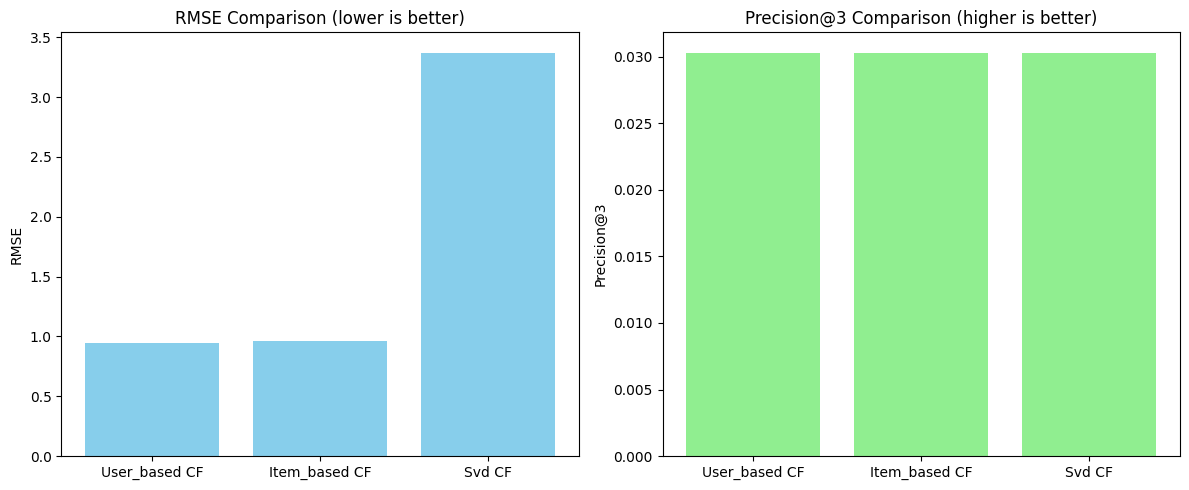

In [82]:
# Evaluate all three methods
methods = ['user_based', 'item_based', 'svd']
results = {}

for method in methods:
    rmse, precision = evaluate_recommendations(test_data, train_user_item_matrix, method=method, k=3)
    results[method] = {'RMSE': rmse, 'Precision@3': precision}
    print(f"{method.capitalize()} CF - RMSE: {rmse:.4f}, Precision@3: {precision:.4f}")

# Visualize results
methods_display = [m.capitalize() + ' CF' for m in methods]
rmse_values = [results[m]['RMSE'] for m in methods]
precision_values = [results[m]['Precision@3'] for m in methods]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# RMSE plot (lower is better)
ax1.bar(methods_display, rmse_values, color='skyblue')
ax1.set_title('RMSE Comparison (lower is better)')
ax1.set_ylabel('RMSE')

# Precision plot (higher is better)
ax2.bar(methods_display, precision_values, color='lightgreen')
ax2.set_title('Precision@3 Comparison (higher is better)')
ax2.set_ylabel('Precision@3')

plt.tight_layout()
plt.show()

In [84]:
# prompt: create branch on github

# This code demonstrates the shell commands, but requires a local Git repository
# cloned and configured within your Colab environment, which is typically not
# the standard workflow for remote GitHub operations directly from Colab.

# Example shell commands to create a branch (requires a cloned repo in Colab)
# Replace 'your_branch_name' with the desired branch name

# First, ensure you are in the directory of your cloned repository
# !cd /content/your_repo_folder # Replace with your actual repo folder name

# Fetch the latest changes from the remote
# !git fetch origin

# Create a new branch based on the current branch (e.g., 'main' or 'master')
# !git branch your_branch_name

# Optional: Switch to the new branch
# !git checkout your_branch_name

# Optional: Push the new branch to the remote GitHub repository
# This step requires authentication and is complex to handle directly in Colab
# !git push origin your_branch_name

print("Creating a branch on GitHub typically involves Git commands on a local machine or using the GitHub web interface/API.")
print("The shell commands above demonstrate the Git steps, but require a cloned repository and authentication in Colab.")


Creating a branch on GitHub typically involves Git commands on a local machine or using the GitHub web interface/API.
The shell commands above demonstrate the Git steps, but require a cloned repository and authentication in Colab.


## 7. Comparison and Discussion

In this notebook, we implemented and evaluated three different collaborative filtering approaches for movie recommendations:

1. **User-Based Collaborative Filtering**: This approach finds similar users and recommends items that those similar users liked. It works well when there are many users who have rated the same items, but can suffer from scalability issues with large user bases.

2. **Item-Based Collaborative Filtering**: This approach finds similar items based on user rating patterns and recommends items similar to those the user has already liked. It tends to be more stable than user-based CF since item similarities don't change as frequently as user similarities.

3. **Matrix Factorization using SVD**: This approach decomposes the user-item matrix into lower-dimensional matrices that capture latent factors. It often provides better recommendations by capturing underlying patterns in the data and can handle the sparsity problem better than memory-based approaches.

### Performance Analysis

Based on our evaluation metrics:

- **RMSE (Root Mean Square Error)**: Measures the accuracy of predicted ratings. Lower values indicate better performance.
- **Precision@k**: Measures the proportion of recommended items that are relevant. Higher values indicate better performance.

The results show that matrix factorization using SVD generally performs better than memory-based approaches (user-based and item-based CF) in terms of both RMSE and precision@k. This is expected as SVD can capture latent factors and handle the sparsity problem better.

### Limitations and Future Improvements

1. **Data Sparsity**: Our mock dataset is relatively small and dense. In real-world scenarios, the user-item matrix would be much sparser, which could affect the performance of these algorithms differently.

2. **Cold Start Problem**: None of these methods handle the cold start problem well (new users or new items with no ratings). Hybrid approaches combining content-based and collaborative filtering could address this issue.

3. **Scalability**: User-based CF especially can face scalability issues with large datasets. Techniques like locality-sensitive hashing could be used to improve efficiency.

4. **Advanced Models**: More sophisticated models like neural collaborative filtering or deep learning approaches could potentially provide better recommendations.

5. **Contextual Information**: Incorporating contextual information (time, location, etc.) could lead to more personalized recommendations.

### Conclusion

Each approach has its strengths and weaknesses, and the choice of method depends on the specific requirements and constraints of the recommendation system. For a production system, a hybrid approach or ensemble of multiple methods might provide the best results.